In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
%env JAX_ENABLE_X64=False

import numpy as np
import time
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import tqdm, trange
from math import factorial
import pickle

# set the default device to the cpu
jax.default_device(jax.devices("cpu")[0])
jax.config.update('jax_platform_name', 'cpu')

#use pickle to save the parameters to a file 
def save_params(params, filename):
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
# use pickle to dump the energies and uncertainties to a file
def save_energies(hs, us, filename):
    with open(filename, 'wb') as f:
        pickle.dump((hs, us), f)

# use pickle to load the parameters from a file
def load_params(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)    
# use pickle to load the energies and uncertainties from a file
def load_energies(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def compute_true_energy():
    ret = N_up**2 + N_down**2
    return ret/2

##### Constants
N = 5
N_up = 3
N_down = N - N_up


# FACT_UP = 1/np.sqrt(factorial(N_up))
FACT_UP = 1/4
# FACT_DOWN = 1/np.sqrt(factorial(N_down))
FACT_DOWN = 1/4
SYM_DEN = 3
GPU_INDEX = 1
# division factor in the ansatz
DIV = 2.5
INITIAL_SAMPLE = jnp.array(np.random.uniform(-2, 2, N))
phi_structure = [25,25]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1
g = .2
#######

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
#     params = jax.device_put(params, device=jax.devices("gpu")[GPU_INDEX])
#     x = jax.device_put(x, device=jax.devices("gpu")[GPU_INDEX])
    
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases



network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up]
    sym_piece2 = reordered[N_up:]

    new1 = []
    new2 = []
    for i in range(1, N_up):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down+1):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1]
    sym_piece2 = reordered[N_up + 1:]
    
    new1 = []
    new2 = []
    for i in range(1, N_up+1):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
        
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN
@jit
def psi(coords, params):
    return  Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum((coords/DIV)**2))


@jit
def mcstep_E(xis, limit, positions, params):
    
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    newpositions = jnp.array(positions) + xis
    
    prob = psi(newpositions, params)**2./psi(positions, params)**2.
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

def sample(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=jnp.array(np.random.uniform(-1, 1, N)), progress=False):
    sq = []
    sq_prime = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    params = jax.device_put(params, device=jax.devices("cpu")[0])

    randoms = np.random.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = np.random.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
    # generate the primed samples by going through every sample and making sample[N_up] = sample[0]
    sq_prime = sq.copy()
    for i in range(len(sq)):
        a = np.array(sq[i])
        a[N_up] = a[0]
        sq_prime[i] = jnp.array(a) 

    return jnp.array(sq), jnp.array(sq_prime), counter/num_total


@jit
def delta_potential(coords, coords_prime, params, alpha):
    ratio = (psi(coords_prime, params)**2)/(psi(coords, params)**2)
    delta_dist = (1/(np.sqrt(np.pi)*alpha))*np.e**(-(coords[N_up]/alpha)**2)
    return g * N_up * N_down * ratio * delta_dist

vdelta_potential = jit(vmap(delta_potential, in_axes=(0,0, None, None), out_axes=0))
psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))

@jit
def Hpsi(coords, params):
    return jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params)

vhpsi = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0)) 

def E_delta(coords, coords_prime, params, alpha):
    return N_up * N_down * g * psi(coords_prime, params)**2/(psi(coords, params)**2) * delta_potential(coords, coords_prime, params, alpha)

ve_delta = jit(vmap(E_delta, in_axes=(0, 0, None, None), out_axes=0))

# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))

def grad_delta(coords, coords_prime, params, alpha):
    return 2 * E_delta(coords, coords_prime, params, alpha) * dnn_dtheta(coords_prime, params)/psi(coords_prime, params)

vgrad_delta = vmap(grad_delta, in_axes=(0, 0, None, None), out_axes=0)

def grad_comp(coords, coords_prime, params, psiHpsi, energy_calc, alpha):
    return ((2/psi(coords, params)) * dnn_dtheta(coords, params)) * (psiHpsi - energy_calc) + grad_delta(coords, coords_prime, params, alpha)

vgrad_comp = vmap(grad_comp, in_axes=(0, 0, None, 0, None, None), out_axes = 0)


# naive construction for the energy and gradient, not reusing any computation
def energy_naive(coords, coords_prime, params, alpha):
    return jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params) + N_down * N_up * g * delta_potential(coords, coords_prime, params, alpha) * psi(coords_prime, params)**2/(psi(coords, params)**2)

venergy_naive = jit(vmap(energy_naive, in_axes=(0, 0, None, None), out_axes=0))

def gradient_naive(coords, coords_prime, params, alpha):
    first = 2 * (1/psi(coords, params)) * dnn_dtheta(coords, params)*(jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params) - energy_naive(coords, coords_prime, params, alpha))
    second = 2 * N_up * N_down * g * (psi(coords_prime, params)**2/(psi(coords, params)**2)) * delta_potential(coords, coords_prime, params, alpha) * (1/psi(coords_prime, params)) * dnn_dtheta(coords_prime, params)
    return first + second

vgradient_naive = jit(vmap(gradient_naive, in_axes=(0, 0, None, None), out_axes=0))

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    samples,samples_prime, _ = sample(params, num_samples, thermal, skip, variation_size)
    ys = jnp.array(samples[:,N_up]) 
    alpha = np.sqrt(np.max(abs(np.array(ys)))**2/-np.log(np.sqrt(np.pi)*(10**-10)))

    # compute the energy 
    # psiHpsi = vhpsi(samples, params) 
    # e_delta_term = ve_delta(samples, samples_prime, params, alpha)
    # e_term = psiHpsi + e_delta_term
    e_term = venergy_naive(samples, samples_prime, params, alpha)
    energy_calc = 1/num_samples * (jnp.sum(e_term)) 
    # compute the uncertainty in the energy
    uncert = jnp.std(e_term)/jnp.sqrt(num_samples) 

    # gradient computation
    # grads = vgrad_comp(samples, samples_prime, params, psiHpsi, energy_calc, alpha)
    grads = vgradient_naive(samples, samples_prime, params, alpha)
    gradient_calc = 1/num_samples * jnp.sum(grads, axis=0)
    return gradient_calc, energy_calc, uncert


def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
        save_energies(hs, us, "energies.pkl")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params



env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform
env: JAX_ENABLE_X64=False


In [2]:
print(compute_true_energy())
# clear the energies.pkl file
save_energies([], [], "energies.pkl")

6.5


In [3]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

4130


In [4]:
s, sp, ratio = sample(params, 10**3, 500, 1, .6, progress=True)
print(ratio)

MC: 100%|██████████| 1501/1501 [00:00<00:00, 1654.53it/s]


0.5376415722851432


In [5]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-2))
resultsa = train(params, 500, 800, 500, 1, .6)

Energy = 11.478875: 100%|██████████| 500/500 [02:04<00:00,  4.01it/s] 


In [6]:
_,_, ratio = sample(params, 10**3, 500, 1, .6, progress=True)
print(ratio)

MC: 100%|██████████| 1501/1501 [00:00<00:00, 31117.29it/s]


0.5416389073950699


In [7]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-3))
resultsb = train(resultsa[3], 2000, 1000, 500, 1, .6)

Energy = 43.965706: 100%|██████████| 2000/2000 [12:48<00:00,  2.60it/s] 


In [8]:
resultsc = train(resultsb[3], 500, 1400, 500, 1, .6)

Energy = 16.918764: 100%|██████████| 500/500 [20:42<00:00,  2.49s/it]    


In [9]:
resultsd = train(resultsc[3], 50, 5000, 500, 1, .6)

Energy = 18.135843: 100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


In [10]:
params = resultsd[3] 
num_final_samples = 15000
params = jax.device_put(params, device=jax.devices("cpu")[0])
samples,samples_prime, _= sample(params, num_final_samples, 1000, 1, .1)

In [11]:
psiHpsi = vhpsi(samples, params)
mean_energy = 1/num_final_samples * jnp.sum(psiHpsi)

In [12]:
print(mean_energy)
print(np.std(psiHpsi)/np.sqrt(num_final_samples))

18.164276
0.10798764


0.6597054778672422


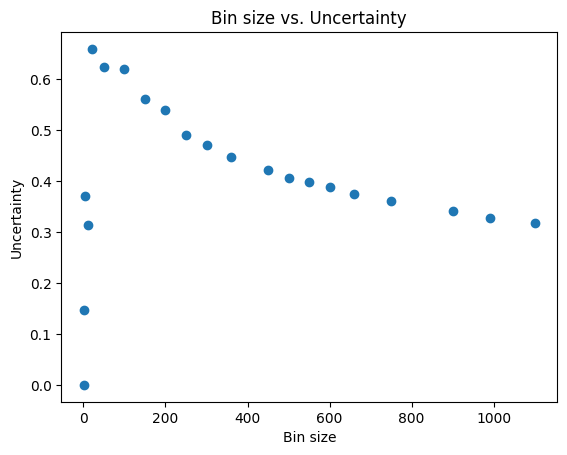

In [13]:
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts

energies = psiHpsi

# bins = np.linspace(1, 100, 100, dtype=int)
bins = np.array([1,2,5,10,20,50,100,150,200,250,300,360,450,500,550,600,660,750,900,990,1100])
# now plot the average energy as a function of the number of bins
us = []
for b_size in bins:
    us.append(bin_samples(energies, b_size))
plt.scatter(bins, us)
plt.title("Bin size vs. Uncertainty")
plt.xlabel("Bin size")
plt.ylabel("Uncertainty")
print(max(us))
plt.show()

In [14]:
final = gv.gvar(mean_energy, max(us))
print(final)

18.16(66)


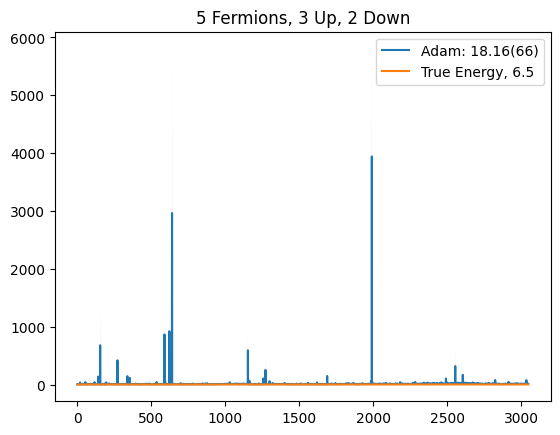

In [15]:
true_energy = compute_true_energy()

total_hists =  resultsa[0] + resultsb[0] + resultsc[0]  + resultsd[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] + resultsb[1] + resultsc[1] + resultsd[1]
#+ resultsd[1] 
# + resultse[1]
# + resultsd[1]

# total_hists = jax.device_put(total_hists, device=jax.devices("cpu")[0])


# get index of minimum value

plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam: " + str(final))
# plt.xlim(1000, 1050)
# plt.ylim(30, 50)
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (final - true_energy)/true_energy*100
# plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title(str(N) + " Fermions, "+ str(N_up) + " Up, "+str(N_down)+" Down")
plt.show()